# SWA144 flights: LIH > LAX (Kauai > Los Angeles)

### Import Python tools and Jupyter configuration

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import altair as alt
import altair_latimes as lat
import datetime as dt
import requests
import glob
from shapely.geometry import Point, LineString, MultiLineString

/Users/mhustiles/.local/share/virtualenvs/notebooks-xu8v5Vvv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = None
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

---

### Grab all the csv files downloaded from FlightRadar24

In [4]:
### https://www.flightradar24.com/data/flights/wn144

path = "data/raw/lih-lax/"
all_files = glob.glob(path + "*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

src = pd.concat(li, axis=0, ignore_index=True)

In [5]:
src.sort_values("UTC", ascending=False).head()

,Timestamp,UTC,Callsign,Position,Altitude,Speed,Direction
7848,1628827592,2021-08-13T04:06:32Z,SWA144,"33.947266,-118.400299",0,7,182
7847,1628827586,2021-08-13T04:06:26Z,SWA144,"33.947498,-118.400299",0,7,185
7846,1628827578,2021-08-13T04:06:18Z,SWA144,"33.947777,-118.400261",0,8,185
7845,1628827568,2021-08-13T04:06:08Z,SWA144,"33.948132,-118.400246",0,8,165
7844,1628827560,2021-08-13T04:06:00Z,SWA144,"33.948395,-118.400398",0,8,123


### Clean up column names

In [6]:
src.columns = src.columns.str.lower()

### Convert UTC dates to Pacific time

In [7]:
src["datetime_utc"] = pd.to_datetime(src.utc).dt.tz_convert("US/Pacific")

In [8]:
src["date_pacfic"] = src["datetime_utc"].dt.date.astype(str)

In [9]:
src["time_pacfic"] = src["datetime_utc"].dt.time.astype(str)

### Make a unique ID for each flight

In [10]:
src["id"] = (
    src["callsign"]
    + "_"
    + src["date_pacfic"].astype(str).str.replace("-", "", regex=False)
)

---

### Summary stats on our dataframe

In [11]:
df = src.copy()

### Group by flight and mean speed

In [12]:
mean_speed_flight = (
    df[df["speed"] > 150].groupby(["id"]).agg({"speed": "mean"}).reset_index()
)

### 'Slowest' flights? 

In [13]:
mean_speed_flight.sort_values("speed", ascending="false").head()

,id,speed
18,SWA144_20210806,311.379822
19,SWA144_20210807,311.503268
4,SWA144_20210723,313.979167
13,SWA144_20210801,315.271739
20,SWA144_20210808,316.611801


### 'Fastest' flights? 

In [14]:
mean_speed_flight.sort_values("speed", ascending="false").tail()

,id,speed
12,SWA144_20210731,347.144487
14,SWA144_20210802,355.096847
23,SWA144_20210811,355.704142
1,SWA144_20210720,362.317536
10,SWA144_20210729,369.067669


### Group by flight and mean altitude

In [15]:
mean_altitude_flight = (
    df[df["altitude"] > 0].groupby(["id"]).agg({"altitude": "mean"}).reset_index()
)

### 'Highest' flights?

In [16]:
mean_altitude_flight.sort_values("altitude", ascending="false").tail()

,id,altitude
9,SWA144_20210728,17819.834711
14,SWA144_20210802,17843.362832
23,SWA144_20210811,18150.939306
10,SWA144_20210729,18768.906810
1,SWA144_20210720,19795.111111


### 'Lowest' flights?

In [17]:
mean_altitude_flight.sort_values("altitude", ascending="false").head()

,id,altitude
19,SWA144_20210807,13239.758065
13,SWA144_20210801,14319.278169
20,SWA144_20210808,14338.939394
22,SWA144_20210810,14507.544757
18,SWA144_20210806,14685.734870


### Split the lat/lon and make a geodataframe

In [18]:
df[["latitude", "longitude"]] = df["position"].str.split(",", expand=True)

### Drop what we don't need

In [19]:
df.drop(
    ["utc", "position", "timestamp", "datetime_utc", "callsign"],
    axis=1,
    inplace=True,
)

In [20]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

### Simple plot

<AxesSubplot:>

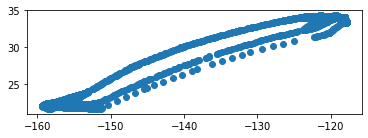

In [21]:
gdf.plot()

In [22]:
gdf.head()

,altitude,speed,direction,date_pacfic,time_pacfic,id,latitude,longitude,geometry
0,0,0,315,2021-07-27,15:52:59,SWA144_20210727,21.977486,-159.348892,POINT (-159.34889 21.97749)
1,0,5,315,2021-07-27,16:01:18,SWA144_20210727,21.977312,-159.348663,POINT (-159.34866 21.97731)
2,0,4,286,2021-07-27,16:01:32,SWA144_20210727,21.977114,-159.34845,POINT (-159.34845 21.97711)
3,0,3,233,2021-07-27,16:01:44,SWA144_20210727,21.977055,-159.348236,POINT (-159.34824 21.97706)
4,0,7,225,2021-07-27,16:03:53,SWA144_20210727,21.976835,-159.348465,POINT (-159.34847 21.97684)


### We need lines to plot the flights

In [23]:
gdf_lines = gpd.GeoDataFrame(
    gdf.groupby(["id", "date_pacfic"])["geometry"]
    .apply(lambda x: LineString(x.tolist()))
    .reset_index()
)

<AxesSubplot:>

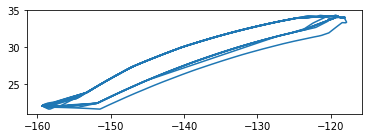

In [24]:
gdf_lines.plot()

---

### Get schedule from FlightRadar24 page

In [25]:
sched = pd.read_csv("data/raw/recent_flights_lih_lax.csv", parse_dates=["date"])

In [26]:
sched["begin"] = sched["begin"].str.replace("(LAX)", "", regex=False)
sched["end"] = sched["end"].str.replace("(LIH)", "", regex=False)

In [27]:
sched[["aircraft", "callsign"]] = sched["plane"].str.split("(", expand=True)

In [28]:
sched["callsign"] = sched["callsign"].str.replace(")", "", regex=False)

In [29]:
sched["land_actual"] = sched["land_actual"].str.replace("Landed ", "", regex=False)

In [30]:
sched.drop(["Unnamed: 9", "Unnamed: 10", "Unnamed: 11", "plane"], axis=1, inplace=True)

In [31]:
sched["flight_time"] = pd.to_datetime(sched["flight_time"], format="%H:%M").dt.time

In [32]:
sched.head()

,date,begin,end,flight_time,leave_sched,leave_actual,land_sched,land_actual,aircraft,callsign
0,2021-08-12,Lihue (LIH),Los Angeles (LAX),05:21:00,12:35 PM,12:36 PM,9:10 PM,8:57 PM,B738,N8305E
1,2021-08-11,Lihue (LIH),Los Angeles (LAX),05:09:00,12:35 PM,12:45 PM,9:10 PM,8:54 PM,B738,N8305E
2,2021-08-10,Lihue (LIH),Los Angeles (LAX),05:00:00,12:35 PM,12:50 PM,9:10 PM,8:50 PM,B738,N8326F
3,2021-08-09,Lihue (LIH),Los Angeles (LAX),04:53:00,12:35 PM,12:50 PM,9:10 PM,8:42 PM,B738,N8305E
4,2021-08-08,Lihue (LIH),Los Angeles (LAX),04:57:00,12:35 PM,12:39 PM,9:10 PM,8:35 PM,B38M,N8718Q


---

### Exports

In [33]:
gdf.to_file("data/processed/lih_lax_flights_points.geojson", driver="GeoJSON")

In [34]:
gdf_lines.to_file("data/processed/lih_lax_flights_lines.geojson", driver="GeoJSON")

In [35]:
import fiona

fiona.supported_drivers["KML"] = "rw"

In [36]:
gdf.to_file("data/processed/lih_lax_flights_points.kml", driver="KML")
gdf_lines.to_file("data/processed/c_flights_lines.kml", driver="KML")

### Our flight

In [37]:
gdf[gdf["date_pacfic"] == "2021-08-10"].to_file(
    "data/processed/lih_lax_flights_points_aug10.kml", driver="KML"
)

In [38]:
gdf_lines[gdf_lines["date_pacfic"] == "2021-08-10"].to_file(
    "data/processed/lih_lax_flights_lines_aug10.kml", driver="KML"
)